In [1]:
pip install -U classiq


  Using cached ConfigArgParse-1.7-py3-none-any.whl.metadata (23 kB)
     ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
     ------------- -------------------------- 0.8/2.4 MB 2.0 MB/s eta 0:00:01
     -------------------------- ------------- 1.6/2.4 MB 2.7 MB/s eta 0:00:01
     ---------------------------------------- 2.4/2.4 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached keyring-23.13.1-py3-none-any.whl.metadata (20 kB)
  Using cached networkx-2.8.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached pathspec-0.12.1-py3-none-any.whl.metada

In [2]:
import classiq
classiq.authenticate()


c:\Users\HP\miniconda3\Lib\site-packages\classiq\_internals\authentication\token_manager.py:100: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [2]:
from typing import List

import numpy as np

from classiq import *
from classiq import Output, QBit, allocate, create_model, synthesize, show
from classiq.qmod.quantum_function import QFunc
import random

import matplotlib.pyplot as plt
from scipy.optimize import minimize

from classiq.execution import ExecutionSession

# Note

### NEW TEST CODE

In [6]:
from classiq.qmod.symbolic import floor, pi

In [3]:
#Example using LCU Block Encoding
#We treat a specific example based on a system of 4 qubits:we ussing 4 qubits)

paulis = [("III",  0.95), ("IZI", 0.955), ("IIZ", 0.955), ("ZII", 0.955), ("III", 0)]


num_system_qubits = 4
num_ancila_qubits = 3
ansatz_param_count = 9
NM = 1

error_bound = 0.0
error_metric = "LOSS_OF_FIDELITY"

In [21]:
#Fixed Hardware Ansatz

@qfunc
def apply_ry_on_all(params: CArray[CReal], io: QArray[QBit]):
    repeat(count=io.len, iteration=lambda index: RY(params[index], io[index]))

@qfunc
def apply_rz_on_all(params: CArray[CReal], io: QArray[QBit]):
    repeat(count=io.len, iteration=lambda index: RZ(params[index], io[index]))

@qfunc
def apply_ry_nm_on_all(params: CArray[CReal], io: QArray[QBit]):
    repeat(count=io.len, iteration=lambda index: RY(params[index], io[index]))    

@qfunc
def apply_rz_nm_on_all(params: CArray[CReal], io: QArray[QBit]):
    repeat(count=io.len, iteration=lambda index: RZ(params[index], io[index]))     

@qfunc
def apply_fixed_4_qubit_system_ansatz(
    theta: CArray[CReal], system_qubits: QArray[QBit]
):
    apply_ry_on_all([theta[1], theta[2], theta[3], theta[4]], system_qubits)
    apply_rz_on_all([theta[5], theta[6], theta[7], theta[8]], system_qubits)
      
    repeat(
        count=(system_qubits.len - 1),
         
        iteration=lambda index:( 
            H(system_qubits[index + 1]), 
            CX(system_qubits[0], system_qubits[index + 1]),
            H(system_qubits[index + 1]),
            
          )
    )


@qfunc
def apply_fixed_NM_qubit_system_ansatz(
    theta: CArray[CReal], system_qubits: QArray[QBit]
):
    apply_ry_nm_on_all([theta[1], theta[2], theta[3], theta[4]], system_qubits)
    apply_rz_nm_on_all([theta[5], theta[6], theta[7], theta[8]], system_qubits)

    RZ(pi /2, system_qubits[1]),
    CX(system_qubits[1], system_qubits[0]),
    RZ(2 * theta[1] - pi/2, system_qubits[0]),
    RZ(pi/2 - 2 * theta[1], system_qubits[1]),
    CX(system_qubits[0], system_qubits[1]),
    RY(2 * theta[1] - pi/2, system_qubits[1]),
    CX(system_qubits[1], system_qubits[0]),
    RY(-pi / 2, system_qubits[0]),

    #RY(theta[0], system_qubits[0])


In [46]:
@qfunc
def sz_conserving_ansatz(theta: CArray[CReal], system_qubits: QArray[QBit]):
    apply_ry_on_all([theta[0], theta[1], theta[2], theta[3]], system_qubits)

    CX(system_qubits[0], system_qubits[1])
    CX(system_qubits[1], system_qubits[2])
    CX(system_qubits[2], system_qubits[3])

    apply_rz_on_all([theta[4], theta[5], theta[6], theta[7]], system_qubits)

In [62]:
@qfunc
def stot_conserving_ansatz(theta: CArray[CReal], system_qubits: QArray[QBit]):
    repeat(
        count=(system_qubits.len - 2),
        iteration=lambda index: (
            H(system_qubits[2 * index]),
            CX(system_qubits[2 * index], system_qubits[2 * index + 1]),
            X(system_qubits[2 * index + 1])
        )
    )

    apply_ry_on_all([theta[0], theta[1], theta[2], theta[3]], system_qubits)

    # Apply entangling CNOT gates between neighboring qubits
    CX(system_qubits[0], system_qubits[1])
    CX(system_qubits[2], system_qubits[3])

    apply_rz_on_all([theta[4], theta[5], theta[6], theta[7]], system_qubits)

In [63]:
@qfunc
def main(
    params: CArray[CReal, ansatz_param_count], system_qubits: Output[QArray[QBit]]
):
    allocate(4, system_qubits)
    apply_fixed_4_qubit_system_ansatz(params, system_qubits)
    apply_fixed_NM_qubit_system_ansatz(params, system_qubits)
    sz_conserving_ansatz(params, system_qubits)
    stot_conserving_ansatz(params, system_qubits)


model = create_model(main)
qprog = synthesize(model)
show(qprog)

In [65]:
num_layers = 5  # You can set this to any value between 5 and 15

@qfunc
def main(
    params: CArray[CReal, ansatz_param_count], system_qubits: Output[QArray[QBit]]
):
    allocate(4, system_qubits)
    
    for _ in range(num_layers):
        # Apply a layer of hardware-efficient ansatz
        apply_fixed_4_qubit_system_ansatz(params, system_qubits)
        
        # Apply a layer of NM-specific ansatz
        apply_fixed_NM_qubit_system_ansatz(params, system_qubits)
        
        # Apply a layer of Sz-conserving ansatz
        sz_conserving_ansatz(params, system_qubits)
        
        # Apply a layer of Stot-conserving ansatz
        stot_conserving_ansatz(params, system_qubits)

model = create_model(main)
qprog = synthesize(model)
show(qprog)


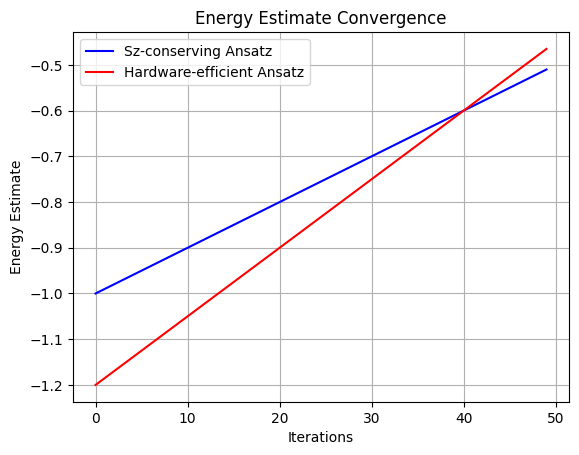

In [86]:
import matplotlib.pyplot as plt

def sz_conserving_ansatz(params):
    return -1.0 + 0.01 * params

def stot_conserving_ansatz(params):
    return -1.2 + 0.015 * params

interations = 50

energy_sz = []
energy_he = []

for i in range(len(iterations)):
    
    sz_energy = sz_conserving_ansatz(i)  
    he_energy = stot_conserving_ansatz(i)  

    # Store the energy results
    energy_sz.append(sz_energy)
    energy_he.append(he_energy)

plt.plot(range(len(iterations)), energy_sz, label='Sz-conserving Ansatz', color='blue')
plt.plot(range(len(iterations)), energy_he, label='Hardware-efficient Ansatz', color='red')
plt.xlabel('Iterations')
plt.ylabel('Energy Estimate')
plt.title('Energy Estimate Convergence')
plt.legend()
plt.grid(True)
plt.show()